In [1]:
#importing the required packages
import tensorflow as tf
from tensorflow.keras.optimizers import Adam 
from tensorflow import keras
from tensorflow.keras import layers
import os 
import numpy as np
from matplotlib import pyplot as plt  
import seaborn as sns

In [2]:
#specifying the path 
DATASET_PATH = "\\Users\\vvsat\\Documents\\machine learning\\Alzheimer_s\\Dataset"  

In [3]:
#defining the classes of the dataset 
disease_cls = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']  

SPLITTTING THE IMAGES INTO TRAIN, TEST AND VALID DATASETS

In [4]:
#splitting the images into train, test and valid datasets with 70, 15 and 15 percentage weightage
import splitfolders 
splitfolders.ratio(DATASET_PATH, output="split", seed=1, ratio=(.7, .15, .15), group_prefix=None)  

IMAGE DATA PREPROCESSING

In [5]:
#importing the required packages 
from tensorflow.keras.preprocessing.image import ImageDataGenerator  

In [6]:
#applying the neccessary preprocessing required for this data
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   featurewise_std_normalization=True,
                                   samplewise_std_normalization=True,
                                   brightness_range=[0.3,0.5],
                                   zoom_range = 0.05, 
                                   horizontal_flip = True) 

validation_datagen = ImageDataGenerator(rescale=1./255, 
                                        featurewise_std_normalization=True,
                                        samplewise_std_normalization=True,
                                        brightness_range=[0.3,0.5],
                                        zoom_range = 0.05, 
                                        horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255,
                                  featurewise_std_normalization=True,
                                  samplewise_std_normalization=True,
                                  brightness_range=[0.3,0.5],
                                  zoom_range = 0.05, 
                                  horizontal_flip = True)


# Read the training sample and set the batch size 
train_generator = train_datagen.flow_from_directory(
        'split/train/',
        target_size=(128, 128),
        batch_size=32,
        seed=100,
        class_mode='categorical')

# Read Validation data from directory and define target size with batch size
validation_generator = validation_datagen.flow_from_directory(
        'split/val/',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',
        seed=500, 
        shuffle=False)

# Read test data from directory and define target size with batch size
test_generator = test_datagen.flow_from_directory(
        'split/test/',
        target_size=(128, 128),
        batch_size=32,
        seed=1000,
        class_mode='categorical',
        shuffle=False)  

C:\Users\vvsat\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\vvsat\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 5848 images belonging to 4 classes.
Found 1766 images belonging to 4 classes.
Found 1787 images belonging to 4 classes.


MODEL BUILDING

HYPERPARAMETER TUNING

In [7]:
#importing the required packages
from tensorflow.keras.models import Sequential 
from tensorflow.keras import regularizers 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D      

FREEZING THE MODEL

In [8]:
#defining a function with all the hyperparameters for tuning  
def model_builder(hp):    
    #defining the hyperparameters units, dropout, lr and weight decay
    hp_units = hp.Int('units', min_value=256, max_value=512, step=10)
    hp_dropout = hp.Choice('drop_out', values=[0.2, 0.3, 0.5, 0.7, 0.8]) 
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01, 0.05, 0.1])
    hp_weight_decay = hp.Choice('weight_decay', values=[0.0001, 0.001, 0.01, 0.05, 0.1])   
    hp_weight_decay_2 = hp.Choice('weight_decay_2', values=[0.0001, 0.001, 0.01, 0.05, 0.1])  
    # building a sequential model 
    model = Sequential()  
    model.add(MobileNetV2(include_top=False,input_tensor=None,input_shape=(128,128,3),
                     pooling='avg',classes=4,weights='imagenet'))     
    #freezing the pretrained layers
    model.layers[0].trainable = False    
    model.add(Flatten())  
    model.add(Dropout(rate = hp_dropout))   
    #fully connected layers
    model.add(Dense(units = hp_units, activation='relu', kernel_regularizer=regularizers.l2(l2 = hp_weight_decay)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(l2 = hp_weight_decay_2)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8))
    model.add(Dense(4, activation='softmax'))
    model.summary()  
    
                                     
    model.compile(optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[['acc'], tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 

    return model   

In [9]:
import keras_tuner as kt 

In [10]:
#creating a hyperband tuner using keras tuner 
tuner = kt.Hyperband(model_builder, 
                     objective='acc', 
                     max_epochs=10, 
                     hyperband_iterations=10,        
                     factor=50,
                     directory='alzheimer_mobilenet_V2',
                     project_name='intro_to_kt')    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [11]:
#early stopping callback to stop the model when the loss shoots up 
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode = 'auto', restore_best_weights=True)    

In [12]:
#run the hyperband tuner
tuner.search(train_generator, callbacks=[stop_early])    
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print('best number of units for the dense layer', best_hps.get('units'))
print('best dropout', best_hps.get('drop_out'))
print('best learning rate', best_hps.get('learning_rate'))
print('best weight decay', best_hps.get('weight_decay'))
print('best weight decay 2', best_hps.get('weight_decay_2'))

Trial 20 Complete [00h 03m 57s]
acc: 0.5347127318382263

Best acc So Far: 0.6085841059684753
Total elapsed time: 01h 15m 39s
INFO:tensorflow:Oracle triggered exit
best number of units for the dense layer 506
best dropout 0.2
best learning rate 0.0001
best weight decay 0.001
best weight decay 2 0.1


CREATING A NEW SEQUENTIAL MODEL

In [13]:
# building the final sequential model 
model = Sequential()  
#adding VGG19 with the imagenet weights
model.add(MobileNetV2(include_top=False,input_tensor=None,input_shape=(128,128,3),
                     pooling='avg',classes=4,weights='imagenet')) 
#freezing the pretrained layers
model.layers[0].trainable = False
#flattening the outputs of the model    
model.add(Flatten())  
#dropping out the a percentage of the model weights 
model.add(Dropout(rate = best_hps.get('drop_out')))   
#fully connected layer
model.add(Dense(units = best_hps.get('units'), activation='relu', 
                kernel_regularizer=regularizers.l2(l2 = best_hps.get('weight_decay'))))
model.add(Dense(128, activation='relu'))
model.add(Dense(64))
model.add(Dense(32, kernel_regularizer=regularizers.l2(l2 = best_hps.get('weight_decay_2'))))
model.add(Dense(16, activation='relu'))
model.add(Dense(8))
model.add(Dense(4, activation='softmax'))
model.summary()                                      

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 506)               648186    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               64896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)               

In [14]:
#compliling the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate = best_hps.get('learning_rate')),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[['acc'], tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 

In [15]:
#training the model
history = model.fit(train_generator, 
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30, 
      validation_data=validation_generator, 
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)   

Epoch 1/30
182/182 [==============================] - 34s 169ms/step - loss: 5.5899 - acc: 0.5087 - auc_1: 0.7984 - precision_1: 0.5922 - recall_1: 0.3069 - val_loss: 5.0709 - val_acc: 0.5685 - val_auc_1: 0.8437 - val_precision_1: 0.6728 - val_recall_1: 0.4168
Epoch 2/30
182/182 [==============================] - 29s 161ms/step - loss: 4.7621 - acc: 0.5520 - auc_1: 0.8328 - precision_1: 0.6567 - recall_1: 0.3547 - val_loss: 4.3851 - val_acc: 0.5838 - val_auc_1: 0.8539 - val_precision_1: 0.6932 - val_recall_1: 0.3941
Epoch 3/30
182/182 [==============================] - 30s 166ms/step - loss: 4.1434 - acc: 0.5710 - auc_1: 0.8442 - precision_1: 0.6764 - recall_1: 0.3764 - val_loss: 3.8460 - val_acc: 0.5747 - val_auc_1: 0.8545 - val_precision_1: 0.6911 - val_recall_1: 0.3851
Epoch 4/30
182/182 [==============================] - 35s 191ms/step - loss: 3.6373 - acc: 0.5814 - auc_1: 0.8517 - precision_1: 0.6836 - recall_1: 0.3923 - val_loss: 3.3879 - val_acc: 0.5912 - val_auc_1: 0.8662 - val

UNFREEZING THE MODEL

In [16]:
#unfreezing the pretrained layers
model.layers[0].trainable = True
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 506)               648186    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               64896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)               

In [17]:
#compliling the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate = best_hps.get('learning_rate')),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[['acc'], tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 

In [18]:
#training the model
history = model.fit(train_generator, 
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30, 
      validation_data=validation_generator, 
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)  

Epoch 1/30
182/182 [==============================] - 33s 147ms/step - loss: 1.0929 - acc: 0.5994 - auc_2: 0.8614 - precision_2: 0.6797 - recall_2: 0.4508 - val_loss: 1.2914 - val_acc: 0.5283 - val_auc_2: 0.8185 - val_precision_2: 0.5462 - val_recall_2: 0.4824
Epoch 2/30
182/182 [==============================] - 25s 137ms/step - loss: 0.8723 - acc: 0.7208 - auc_2: 0.9222 - precision_2: 0.7615 - recall_2: 0.6607 - val_loss: 1.6837 - val_acc: 0.5317 - val_auc_2: 0.8018 - val_precision_2: 0.5321 - val_recall_2: 0.5306
Epoch 3/30
182/182 [==============================] - 25s 138ms/step - loss: 0.7111 - acc: 0.7898 - auc_2: 0.9531 - precision_2: 0.8117 - recall_2: 0.7673 - val_loss: 1.9286 - val_acc: 0.5357 - val_auc_2: 0.7873 - val_precision_2: 0.5360 - val_recall_2: 0.5357
Epoch 4/30
182/182 [==============================] - 25s 139ms/step - loss: 0.5713 - acc: 0.8458 - auc_2: 0.9736 - precision_2: 0.8603 - recall_2: 0.8338 - val_loss: 3.4737 - val_acc: 0.5068 - val_auc_2: 0.7112 - val

SAVING THE MODEL AND ITS WEIGHTS AFTER HYPERPARAMETER TUNING

In [19]:
#saving the model in both hdf5 and normal format
model.save('\\Users\\vvsat\\Documents\\machine learning\\Alzheimer_s\\models\\save\\mobilenet_after_hpt')   

C:\Users\vvsat\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: \Users\vvsat\Documents\machine learning\Alzheimer_s\models\save\mobilenet_after_hpt\assets


INFO:tensorflow:Assets written to: \Users\vvsat\Documents\machine learning\Alzheimer_s\models\save\mobilenet_after_hpt\assets


In [20]:
#saving the model in both hdf5 and normal format
model.save('model_after_hpt_mobilenet.h5')   

In [21]:
#loading the model
#model = keras.models.load_model('model_after_hpt_resnet50.h5') 

PLOTTING THE GRAPHS

In [22]:
train_acc = history.history['acc'] 
val_acc = history.history['val_acc']
train_loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
train_precision = history.history['precision_2'] 
val_precision = history.history['val_precision_2'] 
train_recall = history.history['recall_2']
val_recall = history.history['val_recall_2']
train_auc = history.history['auc_2']
val_auc = history.history['val_auc_2'] 

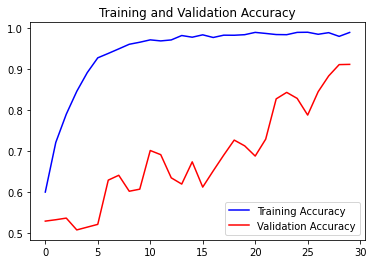

<Figure size 432x288 with 0 Axes>

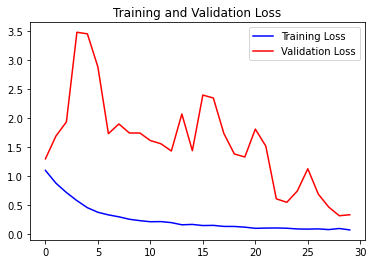

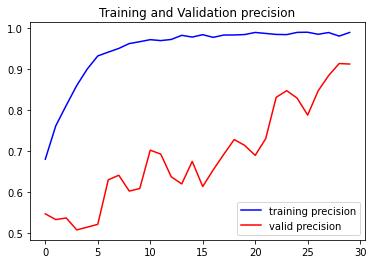

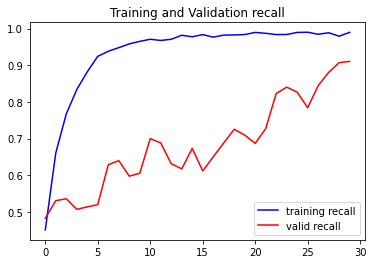

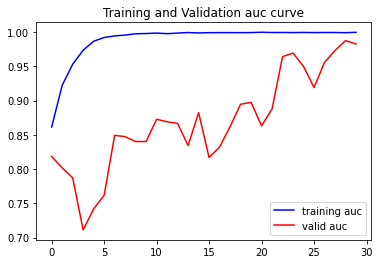

In [23]:
epochs = range(len(train_acc)) 
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_precision, 'b', label='training precision')
plt.plot(epochs, val_precision, 'r', label='valid precision')
plt.title('Training and Validation precision')
plt.legend()
plt.show()

plt.plot(epochs, train_recall, 'b', label='training recall')
plt.plot(epochs, val_recall, 'r', label='valid recall')
plt.title('Training and Validation recall')
plt.legend()
plt.show() 

plt.plot(epochs, train_auc, 'b', label='training auc')
plt.plot(epochs, val_auc, 'r', label='valid auc')
plt.title('Training and Validation auc curve')
plt.legend()
plt.show()

TESTING THE MODEL

In [24]:
#testing the hypermodel on the test dataset
eval_result = model.evaluate(test_generator)
print("[test loss, test accuracy]:", eval_result)  

C:\Users\vvsat\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\vvsat\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


56/56 [==============================] - 7s 122ms/step - loss: 0.3466 - acc: 0.9127 - auc_2: 0.9830 - precision_2: 0.9137 - recall_2: 0.9127
[test loss, test accuracy]: [0.34664303064346313, 0.9127028584480286, 0.9830379486083984, 0.9137254953384399, 0.9127028584480286]


CLASSIFICATION REPORTS AND CONFUSION MATRIX

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
#Confution Matrix and Classification Report
batch_size = 32
#developing the predictions for the test dataset
Y_pred = model.predict(test_generator, test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1) 

<AxesSubplot:>

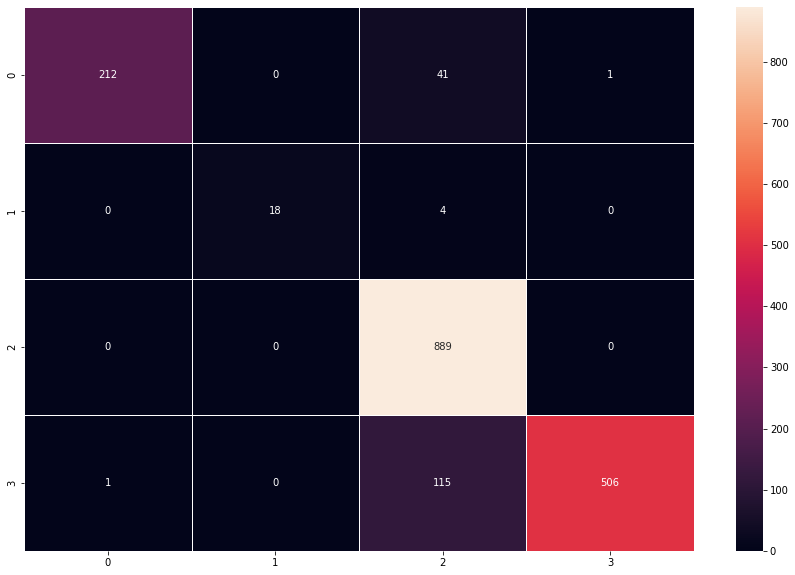

In [27]:
#displaying the confusion matrix
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g') 

In [28]:
#Classification Report
print('Classification Report') 
target_names = disease_cls
print(classification_report(test_generator.classes, y_pred, target_names=target_names)) 

Classification Report
                  precision    recall  f1-score   support

    MildDemented       1.00      0.83      0.91       254
ModerateDemented       1.00      0.82      0.90        22
     NonDemented       0.85      1.00      0.92       889
VeryMildDemented       1.00      0.81      0.90       622

        accuracy                           0.91      1787
       macro avg       0.96      0.87      0.91      1787
    weighted avg       0.92      0.91      0.91      1787



In [29]:
#tf.keras.models.save_model(model, "\\Users\\vvsat\\Documents\\machine learning\\Alzheimer_s\\models")